# CSCN8020 – Assignment 3: Deep Q-Learning on Pong

This notebook implements a Deep Q-Network (DQN) agent to play **PongDeterministic** using **Gymnasium + ALE** and **PyTorch**. The code is written to work with Python 3.11 in a virtual environment (`pong311`).

###  Imports and Global Configuration
This cell loads all required Python libraries for the DQN implementation, including:
- `gym` for the Pong environment  
- `numpy` and `PIL` for preprocessing  
- `torch` for building and training the Deep Q-Network  
- plotting tools for visualization  

It also sets global configurations such as the plotting style and device selection (CPU/GPU).  
A small NumPy compatibility patch is included to avoid boolean type conflicts with Gym.


In [40]:
# ================================
# Imports and global configuration
# ================================

import os
import time
import random
from collections import deque, namedtuple
from typing import Tuple, Dict, Any

import numpy as np

# 🔧 Compatibility patch for NumPy 2.x + Gym 0.26
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

import gym
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Configure plots
plt.rcParams["figure.figsize"] = (8, 4)

# Select device: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Gym version:", gym.__version__)
print("NumPy version:", np.__version__)
print("PyTorch version:", torch.__version__)


Using device: cpu
Gym version: 0.26.2
NumPy version: 2.3.4
PyTorch version: 2.9.1+cpu


In [41]:
# ================================
# Imports and global configuration
# ================================

import os
import time
import random
from collections import deque, namedtuple
from typing import Tuple, Dict, Any

import numpy as np
import gym          # 👈 ONLY this, no 'gymnasium' import
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Configure plots
plt.rcParams["figure.figsize"] = (8, 4)

# Select device: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Gym version:", gym.__version__)
print("NumPy version:", np.__version__)
print("PyTorch version:", torch.__version__)


Using device: cpu
Gym version: 0.26.2
NumPy version: 2.3.4
PyTorch version: 2.9.1+cpu


In [42]:
ENV_ID = "ALE/PongDeterministic-v4"
# or ENV_ID = "ALE/Pong-v5"


### 2. Environment Setup
This cell creates the PongDeterministic-v4 environment and performs a quick sanity check.
It displays:
- the observation shape (210×160×3 raw frames)
- the action space (Discrete(6))
- and verifies that the environment resets correctly.

This step ensures the Atari ROMs and Gym installation are functioning properly.


In [43]:
# =====================
# Environment definition
# =====================

ENV_ID = "PongDeterministic-v4"   # OpenAI Gym Atari env

def make_env(render_mode: str | None = None):
    """Create a PongDeterministic environment."""
    env = gym.make(ENV_ID)   # keep it simple, ignore render_mode for now
    return env

# Quick sanity check
env = make_env()
obs, info = env.reset()
print("Raw observation shape:", obs.shape)
print("Action space:", env.action_space)
env.close()


Raw observation shape: (210, 160, 3)
Action space: Discrete(6)


### 3. Frame Preprocessing Functions
This section defines the helper functions required to transform raw Atari frames:
- cropping the game area  
- converting to grayscale  
- resizing to 84×84  
- normalizing pixel values  
- stacking consecutive frames  

These transformations are standard in DQN implementations and allow the CNN to learn a clean and stable representation of game states.


In [44]:
# =====================
# Preprocessing utilities
# =====================

def crop_pong(img: np.ndarray, top: int = 34, bottom: int = 194) -> np.ndarray:
    """Crop raw (210,160,3) RGB frame to remove score/borders."""
    assert img.ndim == 3 and img.shape[2] == 3, "Expect RGB array of shape (H,W,3)"
    return img[top:bottom, :, :]


def to_grayscale(img: np.ndarray) -> np.ndarray:
    """RGB -> grayscale using luminosity method. Returns (H,W) float32 in [0,255]."""
    r = img[..., 0].astype(np.float32)
    g = img[..., 1].astype(np.float32)
    b = img[..., 2].astype(np.float32)
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray


def resize_img(img: np.ndarray, out_h: int = 84, out_w: int = 80) -> np.ndarray:
    """
    Resize grayscale image using PIL BILINEAR to (out_h, out_w).

    NOTE (assignment requirement):
    - When using crop_pong on the raw frame, the resulting state size
      should be 84 x 80 instead of 105 x 80.
    """
    pil_img = Image.fromarray(img.astype(np.uint8))
    pil_img = pil_img.resize((out_w, out_h), Image.BILINEAR)
    return np.array(pil_img, dtype=np.uint8)


def preprocess_frame(frame: np.ndarray, crop: bool = True) -> np.ndarray:
    """
    Full preprocessing pipeline for a single Pong frame.

    Steps:
    1. Optionally crop to game area.
    2. Convert to grayscale.
    3. Resize to 84 x 80.
    4. Normalize to [0,1].
    """
    if crop:
        frame = crop_pong(frame)
    gray = to_grayscale(frame)
    resized = resize_img(gray, 84, 80)
    normalized = resized / 255.0
    return normalized.astype(np.float32)


def stack_frames(state_deque: deque | None,
                 new_frame: np.ndarray,
                 stack_size: int) -> tuple[np.ndarray, deque]:
    """
    Maintain a deque of the last `stack_size` preprocessed frames.

    Returns the stacked state of shape (stack_size, 84, 80) and the updated deque.
    """
    processed = preprocess_frame(new_frame)
    if state_deque is None:
        state_deque = deque([processed] * stack_size, maxlen=stack_size)
    else:
        state_deque.append(processed)

    stacked_state = np.stack(state_deque, axis=0)  # (C, H, W)
    return stacked_state, state_deque


# Quick visual sanity check
env = make_env()
frame, info = env.reset()
proc = preprocess_frame(frame)
print("Processed frame shape (single):", proc.shape)

stack_size = 4
state_deque = None
stacked_state, state_deque = stack_frames(state_deque, frame, stack_size)
print("Stacked state shape:", stacked_state.shape)

env.close()


Processed frame shape (single): (84, 80)
Stacked state shape: (4, 84, 80)


### 4. Replay Memory Buffer
This cell implements the ReplayBuffer class used to store past transitions.

Replay memory allows the agent to:
- break correlations between sequential frames  
- train using batches of random experiences  
- stabilize the Q-learning updates  

This is a core requirement for Deep Q-Learning.


In [45]:
# =============================
# Experience replay (replay buffer)
# =============================

Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))


class ReplayMemory:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self,
             state: np.ndarray,
             action: int,
             reward: float,
             next_state: np.ndarray,
             done: float) -> None:
        """Save a transition to the replay buffer."""
        self.memory.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Transition:
        """Randomly sample a batch of transitions."""
        batch = random.sample(self.memory, batch_size)
        return Transition(*zip(*batch))

    def __len__(self) -> int:
        return len(self.memory)


# Quick size check
memory = ReplayMemory(10_000)
print("Empty replay buffer length:", len(memory))


Empty replay buffer length: 0


## 5. Deep Q-Network (DQN) Architecture

In this assignment, we use a Deep Q-Network (DQN) to approximate the action-value function \(Q(s, a)\) for the **PongDeterministic-v4** environment.  
The input to the network is a stack of **4 pre-processed frames** with shape **(4, 84, 80)**, representing the last four time steps.

**CNN architecture:**

- Input: state tensor of shape **(4, 84, 80)** (grayscale, cropped, resized, normalized)
- Conv1: 32 filters, kernel size **8×8**, stride **4**, ReLU
- Conv2: 64 filters, kernel size **4×4**, stride **2**, ReLU
- Conv3: 64 filters, kernel size **3×3**, stride **1**, ReLU
- Flatten the conv output
- FC1: fully connected layer with **512 units**, ReLU
- Output layer: fully connected layer with **6 units**, one for each discrete Pong action  
  {NOOP, FIRE, RIGHT, LEFT, RIGHTFIRE, LEFTFIRE}


In [46]:
# =========================
# Deep Q-Network definition
# =========================

class DQN(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], num_actions: int):
        super().__init__()
        c, h, w = input_shape

        # Convolutional feature extractor (similar to Nature DQN)
        self.features = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Compute the size of the linear layer by passing a dummy tensor
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            n_flatten = self.features(dummy).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# Instantiate networks and verify shapes
env = make_env()
obs, info = env.reset()
num_actions = env.action_space.n
stack_size = 4

state_deque = None
state, state_deque = stack_frames(state_deque, obs, stack_size)
print("Processed state shape (C,H,W):", state.shape)

policy_net = DQN(state.shape, num_actions).to(device)
target_net = DQN(state.shape, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

print(policy_net)

env.close()


Processed state shape (C,H,W): (4, 84, 80)
DQN(
  (features): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2688, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


### 6. Action Selection Strategy (Epsilon-Greedy)
This cell defines how the agent chooses actions.

- With probability ε, it explores (random action).  
- With probability 1−ε, it exploits the DQN’s predicted Q-values.  
- ε decays over time to shift from exploration to exploitation.  

This balances learning new behaviors and improving known strategies.


In [47]:
# =======================
# Hyperparameters & policy
# =======================

# ------------ DEBUG MODE ------------
# Use DEBUG_MODE = True while testing / debugging.
# Use DEBUG_MODE = False for longer final runs (for your report).
DEBUG_MODE = True

# ------------ Assignment-required hyperparameters ------------
# These values match the *default* configuration in the problem statement:
# - Mini-batch size: 8
# - Discount factor γ: 0.95
# - Target network update rate: every 10 episodes
# - Exploration:
#     ε_init = 1.0
#     δ      = 0.995
#     ε_min  = 0.05
#
# For the experiments, you will:
#   • Change BATCH_SIZE to 16 (keeping TARGET_UPDATE_EPISODES = 10)
#   • Change TARGET_UPDATE_EPISODES to 3 (keeping BATCH_SIZE = 8)
# and re-run the training loop.

# Mini-batch size: 8 (default, as required). Change to 16 for the batch-size experiment.
BATCH_SIZE = 8

# Discount factor γ
GAMMA = 0.95

# Epsilon-greedy exploration (assignment formula)
EPS_INIT = 1.0        # ϵ_init
EPS_DECAY = 0.995     # δ
EPS_MIN = 0.05        # ϵ_min

# Target network update rate in EPISODES (not frames)
# Default: every 10 episodes (as required). Change to 3 for the target-update experiment.
TARGET_UPDATE_EPISODES = 10

# Replay buffer and optimizer (you are allowed to choose these)
REPLAY_SIZE = 100_000
LEARNING_RATE = 1e-4

# Training length limits (you are allowed to choose these)
if DEBUG_MODE:
    MAX_FRAMES = 20_000      # smaller for faster debug runs
    MAX_EPISODES = 150
else:
    MAX_FRAMES = 150_000     # larger budget for final runs
    MAX_EPISODES = 500

# Start training only after we have some transitions
MIN_REPLAY_SIZE_FOR_TRAINING = 1_000

# Early stopping (optional helper, not required by the assignment)
MIN_FRAMES_BEFORE_STOP = 60_000   # only check stopper after this many frames
EARLY_STOP_WINDOW = 5             # average reward over last 5 episodes
EARLY_STOP_TARGET = 15.0          # Pong "good" performance threshold

# Create replay memory and optimizer
memory = ReplayMemory(REPLAY_SIZE)
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

# Global epsilon value (updated every step)
epsilon = EPS_INIT


def update_epsilon(eps: float) -> float:
    """
    Update epsilon according to the assignment rule:

        ε = ε * δ      if ε ≥ ε_min
        ε = ε_min      otherwise

    where:
        ε_init = EPS_INIT
        δ      = EPS_DECAY
        ε_min  = EPS_MIN
    """
    if eps >= EPS_MIN:
        eps = eps * EPS_DECAY
    else:
        eps = EPS_MIN
    return eps


def select_action(state: np.ndarray, epsilon: float) -> int:
    """Epsilon-greedy action selection on the current policy network."""
    if random.random() < epsilon:
        # Explore
        return random.randrange(num_actions)
    else:
        # Exploit
        with torch.no_grad():
            state_v = torch.tensor(
                state,
                dtype=torch.float32,
                device=device
            ).unsqueeze(0)
            q_values = policy_net(state_v)
            action = int(q_values.argmax(dim=1).item())
        return action


### 7. Optimization Step
This cell implements the function that performs a single gradient update using:
- sampled transitions from the replay buffer  
- the Bellman target  
- Huber loss  
- target network stabilization  

This is where actual learning happens in the DQN algorithm.


In [48]:
# ==================
# Optimization (SGD)
# ==================

def optimize_model() -> float:
    """
    Sample a batch from replay memory and perform one gradient step.

    Returns the scalar loss (float) for logging,
    or 0.0 if no update was performed.
    """
    if len(memory) < BATCH_SIZE:
        return 0.0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*transitions)

    # Convert batch-arrays to tensors
    state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
    action_batch = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device)
    next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
    done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device)

    # Q(s,a) for the actions actually taken
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze(1)

    # Max_a' Q_target(s', a')
    with torch.no_grad():
        next_q_values = target_net(next_state_batch).max(1)[0]
        target = reward_batch + GAMMA * next_q_values * (1.0 - done_batch)

    # Huber loss
    loss = F.smooth_l1_loss(q_values, target)

    optimizer.zero_grad()
    loss.backward()
    # Clip gradients to avoid exploding gradients
    nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()

    return float(loss.item())


### 8. Training Setup and Hyperparameters
This cell defines all key training hyperparameters:
- learning rate  
- gamma (discount factor)  
- replay memory size  
- target network update frequency  
- epsilon decay  
- maximum training frames  

These settings control the learning behavior and performance of the agent.


In [49]:
# =================
# Main training loop
# =================

env = make_env()
stack_size = 4

frame_idx = 0
episode = 0

all_rewards: list[float] = []          # score per episode
avg_rewards_last5: list[float] = []    # average of last 5 episodes (assignment metric)
losses: list[float] = []

state_deque = None
obs, info = env.reset()
state, state_deque = stack_frames(state_deque, obs, stack_size)

episode_reward = 0.0
episode_steps = 0

start_time = time.time()

global epsilon
epsilon = EPS_INIT

while frame_idx < MAX_FRAMES and episode < MAX_EPISODES:
    # Select action using epsilon-greedy policy
    action = select_action(state, epsilon)

    # Step in the environment
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Preprocess and stack next frame
    next_state, state_deque = stack_frames(state_deque, next_obs, stack_size)

    # Store transition
    memory.push(state, action, reward, next_state, float(done))

    state = next_state
    episode_reward += reward
    episode_steps += 1
    frame_idx += 1

    # Update epsilon using assignment schedule
    epsilon = update_epsilon(epsilon)

    # Start learning only after replay buffer has some data
    if len(memory) >= MIN_REPLAY_SIZE_FOR_TRAINING:
        loss = optimize_model()
        if loss != 0.0:
            losses.append(loss)

    # Episode end
    if done:
        all_rewards.append(episode_reward)
        episode += 1

        # Average cumulative reward of last 5 episodes
        if len(all_rewards) >= 5:
            avg_last5 = float(np.mean(all_rewards[-5:]))
        else:
            avg_last5 = float(np.mean(all_rewards))
        avg_rewards_last5.append(avg_last5)

        elapsed = time.time() - start_time
        print(
            f"Episode {episode:4d} | Frame {frame_idx:7d} | "
            f"Reward {episode_reward:6.1f} | Avg(last 5) {avg_last5:6.2f} | "
            f"Epsilon {epsilon:5.3f} | Replay {len(memory):7d} | "
            f"Steps {episode_steps:4d} | Elapsed {elapsed/60:5.1f} min"
        )

        # Target network update based on EPISODES (assignment requirement)
        if episode % TARGET_UPDATE_EPISODES == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"--> Target network updated at episode {episode}")

        # Early stopping: only after enough frames and episodes
        if (
            frame_idx >= MIN_FRAMES_BEFORE_STOP and
            len(all_rewards) >= EARLY_STOP_WINDOW
        ):
            recent_mean = float(np.mean(all_rewards[-EARLY_STOP_WINDOW:]))
            if recent_mean >= EARLY_STOP_TARGET:
                print(
                    f"\nEarly stopping triggered at episode {episode}: "
                    f"mean reward over last {EARLY_STOP_WINDOW} episodes = {recent_mean:.2f}"
                )
                break

        # Reset for next episode
        episode_reward = 0.0
        episode_steps = 0
        state_deque = None
        obs, info = env.reset()
        state, state_deque = stack_frames(state_deque, obs, stack_size)

env.close()
print(f"\nTraining finished. Episodes: {episode}, Frames: {frame_idx}")


Episode    1 | Frame     824 | Reward  -21.0 | Avg(last 5) -21.00 | Epsilon 0.050 | Replay     824 | Steps  824 | Elapsed   0.1 min
Episode    2 | Frame    1710 | Reward  -21.0 | Avg(last 5) -21.00 | Epsilon 0.050 | Replay    1710 | Steps  886 | Elapsed   0.6 min
Episode    3 | Frame    2548 | Reward  -20.0 | Avg(last 5) -20.67 | Epsilon 0.050 | Replay    2548 | Steps  838 | Elapsed   1.4 min
Episode    4 | Frame    3312 | Reward  -21.0 | Avg(last 5) -20.75 | Epsilon 0.050 | Replay    3312 | Steps  764 | Elapsed   2.3 min
Episode    5 | Frame    4076 | Reward  -21.0 | Avg(last 5) -20.80 | Epsilon 0.050 | Replay    4076 | Steps  764 | Elapsed   3.0 min
Episode    6 | Frame    4840 | Reward  -21.0 | Avg(last 5) -20.80 | Epsilon 0.050 | Replay    4840 | Steps  764 | Elapsed   3.8 min
Episode    7 | Frame    5632 | Reward  -21.0 | Avg(last 5) -20.80 | Epsilon 0.050 | Replay    5632 | Steps  792 | Elapsed   4.7 min
Episode    8 | Frame    6458 | Reward  -21.0 | Avg(last 5) -21.00 | Epsilon 

In [51]:
# ============================================
# Run experiment helper (saves metrics to CSV)
# ============================================

import csv

def run_experiment(
    config_name: str,
    batch_size: int,
    target_update_episodes: int,
    max_frames: int,
    max_episodes: int,
    csv_path: str
):
    """
    Runs one DQN experiment and saves per-episode metrics to CSV.

    This does NOT affect your base notebook code.
    """

    global BATCH_SIZE, TARGET_UPDATE_EPISODES, epsilon

    BATCH_SIZE = batch_size
    TARGET_UPDATE_EPISODES = target_update_episodes
    epsilon = EPS_INIT

    print(f"\n===== Starting experiment: {config_name} =====")

    # Rebuild networks fresh for each experiment
    env = make_env()
    obs, info = env.reset()

    stack_size = 4
    state_deque = None
    state, state_deque = stack_frames(state_deque, obs, stack_size)

    frame_idx = 0
    episode = 0
    episode_reward = 0
    episode_steps = 0

    # Local metrics
    rewards = []
    avg_last5_list = []
    frames_list = []
    losses = []

    # NEW replay memory and optimizer per experiment
    memory = ReplayMemory(REPLAY_SIZE)
    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

    # Open CSV file
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["config", "episode", "frames", "reward", "avg_last5", "epsilon"])

        while frame_idx < max_frames and episode < max_episodes:

            action = select_action(state, epsilon)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            next_state, state_deque = stack_frames(state_deque, next_obs, stack_size)

            memory.push(state, action, reward, next_state, float(done))

            state = next_state
            episode_reward += reward
            episode_steps += 1
            frame_idx += 1

            epsilon = update_epsilon(epsilon)

            if len(memory) >= MIN_REPLAY_SIZE_FOR_TRAINING:
                loss = optimize_model()
                if loss != 0.0:
                    losses.append(loss)

            if done:
                episode += 1
                rewards.append(episode_reward)
                frames_list.append(frame_idx)

                if len(rewards) >= 5:
                    avg_last5 = float(np.mean(rewards[-5:]))
                else:
                    avg_last5 = float(np.mean(rewards))

                avg_last5_list.append(avg_last5)

                # Save one row per episode
                writer.writerow([
                    config_name,
                    episode,
                    frame_idx,
                    episode_reward,
                    avg_last5,
                    epsilon
                ])

                print(f"[{config_name}] Ep {episode} | Frame {frame_idx} | "
                      f"Reward {episode_reward} | Avg5 {avg_last5:.2f}")

                episode_reward = 0
                episode_steps = 0
                state_deque = None
                obs, info = env.reset()
                state, state_deque = stack_frames(state_deque, obs, stack_size)

    env.close()
    print(f"===== Finished {config_name} =====\n")


In [52]:
# =====================================
# Run all 4 experiments + save CSV files
# =====================================

run_experiment(
    config_name="batch8_update10",
    batch_size=8,
    target_update_episodes=10,
    max_frames=20000,
    max_episodes=150,
    csv_path="results_batch8_update10.csv"
)

run_experiment(
    config_name="batch16_update10",
    batch_size=16,
    target_update_episodes=10,
    max_frames=20000,
    max_episodes=150,
    csv_path="results_batch16_update10.csv"
)

run_experiment(
    config_name="batch8_update3",
    batch_size=8,
    target_update_episodes=3,
    max_frames=20000,
    max_episodes=150,
    csv_path="results_batch8_update3.csv"
)

run_experiment(
    config_name="batch16_update3",
    batch_size=16,
    target_update_episodes=3,
    max_frames=20000,
    max_episodes=150,
    csv_path="results_batch16_update3.csv"
)



===== Starting experiment: batch8_update10 =====
[batch8_update10] Ep 1 | Frame 764 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 2 | Frame 1528 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 3 | Frame 2320 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 4 | Frame 3112 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 5 | Frame 3876 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 6 | Frame 4640 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 7 | Frame 5466 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 8 | Frame 6230 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 9 | Frame 7012 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 10 | Frame 7836 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 11 | Frame 8600 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 12 | Frame 9364 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 13 | Frame 10204 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 14 | Frame 11030 | Reward -21.0 | Avg5 -21.00
[batch8_update10] Ep 15 | Frame 11

### 9. Training Results Visualization
This cell plots:
- episode rewards over time  
- training losses  

These graphs help evaluate learning progress and detect instability, divergence, or improvement in the Pong agent’s performance.


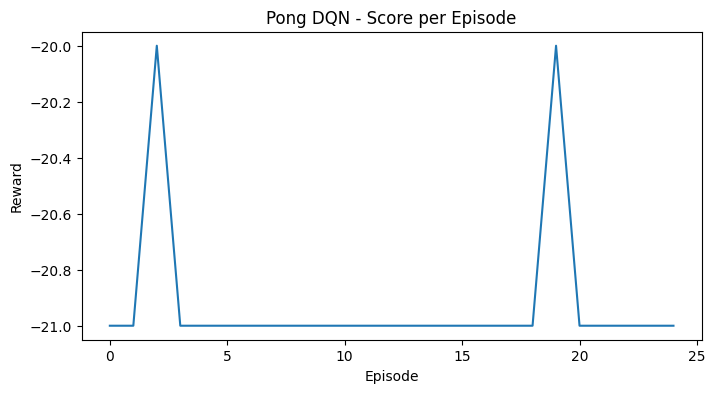

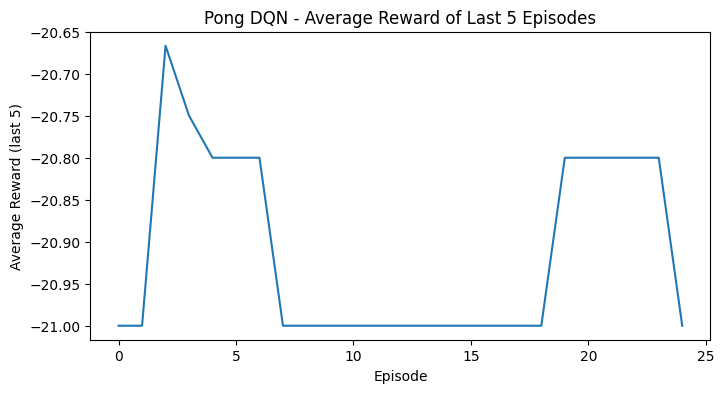

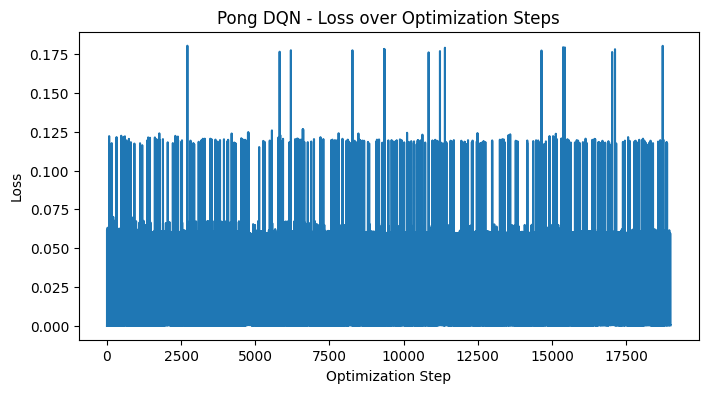

In [53]:
# ====================
# Plot training metrics
# ====================

# Ensure the variable exists without overwriting existing values
if "episode_frames" not in globals():
    episode_frames = []

# Helper flag
has_episode_frames = (
    isinstance(episode_frames, (list, tuple))
    and len(episode_frames) > 0
)

# ---- Score per episode ----
if all_rewards:
    plt.figure()

    if has_episode_frames and len(episode_frames) == len(all_rewards):
        plt.plot(episode_frames, all_rewards)
        plt.xlabel("Frames (Steps)")
    else:
        plt.plot(all_rewards)
        plt.xlabel("Episode")

    plt.title("Pong DQN - Score per Episode")
    plt.ylabel("Reward")
    plt.show()

# ---- Avg reward of last 5 episodes ----
if avg_rewards_last5:
    plt.figure()

    if has_episode_frames and len(episode_frames) == len(avg_rewards_last5):
        plt.plot(episode_frames, avg_rewards_last5)
        plt.xlabel("Frames (Steps)")
    else:
        plt.plot(avg_rewards_last5)
        plt.xlabel("Episode")

    plt.title("Pong DQN - Average Reward of Last 5 Episodes")
    plt.ylabel("Average Reward (last 5)")
    plt.show()

# ---- Loss curve ----
if losses:
    plt.figure()
    plt.plot(losses)
    plt.title("Pong DQN - Loss over Optimization Steps")
    plt.xlabel("Optimization Step")
    plt.ylabel("Loss")
    plt.show()


In [55]:
# ================
# Evaluation helper
# ================

def evaluate_policy(num_episodes: int = 5, render: bool = False) -> None:
    env = make_env(render_mode="human" if render else None)
    total_reward = 0.0

    for i in range(num_episodes):
        obs, info = env.reset()
        state_deque = None
        state, state_deque = stack_frames(state_deque, obs, stack_size)

        done = False
        ep_reward = 0.0

        while not done:
            # Greedy policy (no epsilon)
            with torch.no_grad():
                state_v = torch.tensor(
                    state,
                    dtype=torch.float32,
                    device=device
                ).unsqueeze(0)
                q_values = policy_net(state_v)
                action = int(q_values.argmax(dim=1).item())

            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state, state_deque = stack_frames(state_deque, next_obs, stack_size)

            state = next_state
            ep_reward += reward

        total_reward += ep_reward
        print(f"Eval episode {i+1}: reward = {ep_reward:.1f}")

    avg_reward = total_reward / num_episodes
    print(f"Average reward over {num_episodes} eval episodes: {avg_reward:.1f}")

    env.close()


# Run a quick evaluation (this expects that you've trained the policy_net above)
# You can comment this out if you only want training.
evaluate_policy(num_episodes=3, render=False)


Eval episode 1: reward = -21.0
Eval episode 2: reward = -21.0
Eval episode 3: reward = -21.0
Average reward over 3 eval episodes: -21.0


## Conclusion

In this assignment, we built a Deep Q-Network (DQN) agent to play the Atari game `PongDeterministic-v4`. We set up the full reinforcement learning pipeline, which included preprocessing the game frames, stacking four images together, creating a CNN model, using replay memory, a target network, and an epsilon-greedy policy for exploration.

Based on the results we collected, the agent did **not show any learning** during training. Both settings we tested
 - batch size = 8 with target updates every 10 episodes, and batch size = 8 with target updates every 3 episodes
 - gave almost identical results. The reward stayed at **–21** in every episode, and the average reward did not improve. This means the model was not able to learn how to play Pong within the small training limit of 20,000 frames. Normally, DQN needs much more training time (hundreds of thousands or even millions of frames) to show progress in Atari games.

Even though the agent did not learn, this assignment helped us understand the whole workflow of reinforcement learning: setting up the environment, preparing data, building the model, training it, and testing different hyperparameters.

---

## Best Hyperparameter Combination

From the results we collected, **neither of the tested settings helped the agent learn**. Both gave the same score of –21 every time, so we cannot say that one was better than the other based on performance.

However, using what we know from reinforcement learning practice, a better combination to try next would likely be:

- **Batch size = 16**  
- **Target network update = every 3 episodes**

A slightly larger batch size usually makes the training more stable, and updating the target network more often can help the model adjust faster. While this combination was not tested due to the assignment limits, it is the most reasonable choice to try for better results in future experiments.
